In [43]:
import csv
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from collections import Counter
from sentence_transformers import SentenceTransformer, util
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm

In [44]:
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

In [45]:
# Data link: https://www.kaggle.com/datasets/karnikakapoor/video-ads-engagement-dataset?resource=download
campaign_ctr = Counter()
data_dir = "../data/Advertising"
with open(os.path.join(data_dir, "ad_df.csv")) as f:
    reader = csv.DictReader(f)
    for r in reader:
        campaign_ctr[r['campaign_id']] += 1

In [46]:
top_campaigns = {x[0] for x in sorted(campaign_ctr.items(), key=lambda x: -1*x[1])[:100]}

In [47]:
top_campaigns

{'124391',
 '184750',
 '191254',
 '197246',
 '197257',
 '197349',
 '197912',
 '198951',
 '205843',
 '208037',
 '208435',
 '208469',
 '208878',
 '209150',
 '210361',
 '210362',
 '210633',
 '210635',
 '210685',
 '210702',
 '210802',
 '211167',
 '211305',
 '211331',
 '211332',
 '211499',
 '211516',
 '211518',
 '211520',
 '211521',
 '211522',
 '211733',
 '211831',
 '211853',
 '211950',
 '211998',
 '212176',
 '212229',
 '212246',
 '212923',
 '212971',
 '213012',
 '213131',
 '213287',
 '213314',
 '213315',
 '213336',
 '213351',
 '213370',
 '213453',
 '213454',
 '213708',
 '213745',
 '213746',
 '213783',
 '213877',
 '213879',
 '213912',
 '213956',
 '214002',
 '214003',
 '214126',
 '214175',
 '214320',
 '214323',
 '214397',
 '214483',
 '214490',
 '214515',
 '214520',
 '214593',
 '214626',
 '214627',
 '214630',
 '214631',
 '214633',
 '214647',
 '214693',
 '214698',
 '214774',
 '214871',
 '214873',
 '214875',
 '214879',
 '214881',
 '214883',
 '214937',
 '215116',
 '215197',
 '215250',
 '215393',

In [48]:
full_dset = []

In [49]:
rand_prob = .005
gen = np.random.default_rng(seed=0)

In [50]:
with open(os.path.join(data_dir, "ad_df.csv")) as f:
    reader = csv.DictReader(f)
    for r in reader:
        if r['campaign_id'] in top_campaigns and len(r['referer_deep_three']) and gen.random() < rand_prob:
            full_dset.append([r['campaign_id'], r['advertiser_id'], 
                              r['creative_duration'], r['placement_language'],
                              r['referer_deep_three'], r['ua_country'], r['ua_os'], 
                              r['ua_browser'], r['user_average_seconds_played'], r['seconds_played']])

In [51]:
len(full_dset)

10493

In [52]:
campaign_to_advertiser = {}
for x in full_dset:
    campaign_to_advertiser[x[0]] = x[1]

In [53]:
sorted(campaign_to_advertiser.items(), key=lambda x: x[1])

[('215482', ''),
 ('211522', ''),
 ('214647', ''),
 ('214631', '1328.0'),
 ('214483', '1328.0'),
 ('214627', '1328.0'),
 ('214633', '1328.0'),
 ('214490', '1328.0'),
 ('214630', '1328.0'),
 ('214626', '1328.0'),
 ('213956', '1355.0'),
 ('212176', '1413.0'),
 ('213314', '1428.0'),
 ('213315', '1428.0'),
 ('214175', '1476.0'),
 ('211167', '1575.0'),
 ('210685', '1590.0'),
 ('210802', '1590.0'),
 ('210702', '1590.0'),
 ('212246', '1790.0'),
 ('211520', '1935.0'),
 ('211521', '1935.0'),
 ('211516', '1935.0'),
 ('211499', '1935.0'),
 ('211518', '1935.0'),
 ('211733', '1935.0'),
 ('214320', '1964.0'),
 ('214323', '1964.0'),
 ('208878', '2014.0'),
 ('211950', '2037.0'),
 ('211332', '2168.0'),
 ('211331', '2168.0'),
 ('215548', '2211.0'),
 ('215401', '2244.0'),
 ('214002', '2295.0'),
 ('214003', '2295.0'),
 ('215116', '2851.0'),
 ('214693', '2867.0'),
 ('214698', '2867.0'),
 ('198951', '2886.0'),
 ('214126', '2908.0'),
 ('211305', '2997.0'),
 ('213287', '2998.0'),
 ('212971', '3387.0'),
 ('191

In [54]:
advertiser_ids = list(sorted(set(campaign_to_advertiser.values())))

In [55]:
# Break out the campaign id, placement_language, ua_country, ua_os, and ua_browser into one-hot encodings, 
# and also get embeddings for the referer_deep_three feature

# Maybe actually encode both the 2nd and 3rd levels
# vocab = set()
# for x in tqdm(full_dset):
#     lvls = x[4].split("/")
#     lvls += [""]*(3-len(lvls))
#     vocab |= {lvls[-2].strip(), lvls[-1].strip()}
# len(vocab)    

In [56]:
# sorted_vocab = sorted(list(vocab))

In [57]:
# len(sorted_vocab)
# pickle.dump(sorted_vocab, open("data/Advertising/sorted_vocab.pkl", 'wb'))

In [58]:
# vocab_embs = []
# chunk = 100
# for idx in tqdm(range(len(vocab)//chunk + 1)):
#     vocab_embs.extend(model.encode(sorted_vocab[idx:min(len(sorted_vocab), idx+chunk)]))

In [59]:
fname = os.path.join(data_dir, "vocab_embs.pkl")
# pickle.dump(vocab_embs, open("data/Advertising/vocab_embs.pkl", 'wb'))
vocab_embs = pickle.load(open(fname, 'rb'))
fname = os.path.join(data_dir, "sorted_vocab.pkl")
sorted_vocab = pickle.load(open(fname, 'rb'))

In [60]:
vocab_embs[0].shape

(768,)

In [61]:
df = pd.DataFrame(full_dset)

In [62]:
df.columns = ['campaign_id','advertiser_id', 'creative_duration', 'placement_language', 
              'referer_deep_three', 'ua_country', 'ua_os', 'ua_browser', 'user_average_seconds_played', 'seconds_played']

In [63]:
df_dummies = pd.get_dummies(df, columns=['campaign_id','placement_language', 'ua_country', 'ua_os', 'ua_browser'])

In [64]:
embs = np.zeros((len(full_dset), 768*2))
for idx, x in tqdm(enumerate(full_dset)):
    lvls = x[4].split("/")
    lvls += [""]*(3-len(lvls))
    embs[idx, :768] = vocab_embs[sorted_vocab.index(lvls[-2].strip())]
    embs[idx, 768:] = vocab_embs[sorted_vocab.index(lvls[-1].strip())]

0it [00:00, ?it/s]

In [65]:
df_dummies = df_dummies.drop(columns=['referer_deep_three', 'advertiser_id'])

In [66]:
list(df_dummies.columns)

['creative_duration',
 'user_average_seconds_played',
 'seconds_played',
 'campaign_id_124391',
 'campaign_id_184750',
 'campaign_id_191254',
 'campaign_id_197246',
 'campaign_id_197257',
 'campaign_id_197349',
 'campaign_id_197912',
 'campaign_id_198951',
 'campaign_id_205843',
 'campaign_id_208037',
 'campaign_id_208435',
 'campaign_id_208469',
 'campaign_id_208878',
 'campaign_id_209150',
 'campaign_id_210361',
 'campaign_id_210362',
 'campaign_id_210633',
 'campaign_id_210635',
 'campaign_id_210685',
 'campaign_id_210702',
 'campaign_id_210802',
 'campaign_id_211167',
 'campaign_id_211305',
 'campaign_id_211331',
 'campaign_id_211332',
 'campaign_id_211499',
 'campaign_id_211516',
 'campaign_id_211518',
 'campaign_id_211520',
 'campaign_id_211521',
 'campaign_id_211522',
 'campaign_id_211733',
 'campaign_id_211831',
 'campaign_id_211853',
 'campaign_id_211950',
 'campaign_id_211998',
 'campaign_id_212176',
 'campaign_id_212229',
 'campaign_id_212246',
 'campaign_id_212923',
 'campa

In [67]:
embs = pd.DataFrame(embs)

In [68]:
embs[:10]

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,0.027784,0.047202,-0.010876,0.095864,-0.014336,0.028297,-0.051273,0.032479,0.068720,0.031993,...,0.021388,-0.014516,0.045246,0.004600,-0.027450,-0.054890,0.009458,-0.010986,-0.030796,-0.021520
1,-0.020265,-0.032737,-0.027273,0.085705,-0.034904,0.027943,-0.032076,-0.023835,0.027494,-0.010151,...,-0.039331,-0.034330,-0.024178,-0.011741,-0.016793,0.090289,-0.007154,0.014096,-0.039638,-0.041874
2,-0.005945,0.005390,-0.006077,0.071529,0.025388,-0.012745,0.048069,-0.020013,0.052446,0.010897,...,0.021388,-0.014516,0.045246,0.004600,-0.027450,-0.054890,0.009458,-0.010986,-0.030796,-0.021520
3,0.012271,0.008988,-0.009352,0.085603,-0.030366,0.027193,-0.046770,0.001877,0.009155,-0.008132,...,0.000713,-0.038265,0.004608,-0.009435,-0.034728,-0.006347,-0.001462,0.024552,0.013414,-0.042175
4,0.016959,-0.019917,-0.007092,0.111284,-0.041047,0.000312,-0.013700,-0.009160,0.044137,-0.013007,...,-0.065439,-0.016411,-0.016732,-0.007972,-0.019951,-0.017936,0.010354,-0.034208,-0.022828,-0.063246
5,0.043788,0.053650,0.014296,0.067872,-0.046509,-0.009361,-0.002462,0.015553,0.033761,-0.027542,...,-0.016822,-0.023132,-0.021015,-0.005174,-0.000301,0.061557,0.009487,0.014414,-0.000384,-0.056447
6,0.056821,0.019794,0.003355,0.045874,-0.058656,-0.012505,-0.010499,0.023427,0.064167,-0.002275,...,-0.042933,-0.056517,0.006019,-0.005139,-0.018081,0.022688,0.001619,0.014257,0.015371,-0.066681
7,0.016614,0.033328,-0.000899,0.112945,-0.028835,-0.013752,-0.011304,0.028817,0.041688,-0.023697,...,-0.016822,-0.023132,-0.021015,-0.005174,-0.000301,0.061557,0.009487,0.014414,-0.000384,-0.056447
8,0.007257,0.025274,-0.008864,0.104797,-0.010280,-0.016624,0.020302,-0.016626,0.041220,0.004362,...,-0.031861,-0.036831,-0.053912,-0.053342,-0.038274,-0.004708,-0.029724,-0.005160,0.014245,-0.077273
9,0.010871,-0.000312,-0.029308,0.123859,-0.006104,0.035437,-0.004928,0.038769,0.018683,0.015656,...,-0.044657,-0.028073,0.004691,0.014291,-0.033981,-0.041071,0.014619,0.029805,0.068564,-0.022144


In [139]:
joined = df_dummies.join(embs)

In [140]:
y = joined['seconds_played']

In [145]:
joined['user_average_seconds_played'] = joined['user_average_seconds_played'].replace("", 0.0)

In [146]:
np.any(joined['user_average_seconds_played'] == '')

False

In [147]:
all_x_cols = joined.columns.tolist()
all_x_cols.remove("seconds_played")

In [148]:
random_idxs = sorted(range(joined.shape[0]), key=lambda x: gen.random())

In [149]:
train_cutoff = int(.8*len(random_idxs))
train_idxs = random_idxs[:train_cutoff]
test_idxs = random_idxs[train_cutoff:]

In [150]:
joined

,creative_duration,user_average_seconds_played,seconds_played,campaign_id_124391,campaign_id_184750,campaign_id_191254,campaign_id_197246,campaign_id_197257,campaign_id_197349,campaign_id_197912,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,14,0.0,0,0,0,0,0,0,0,0,...,0.021388,-0.014516,0.045246,0.004600,-0.027450,-0.054890,0.009458,-0.010986,-0.030796,-0.021520
1,30,19.200000762939453,30,0,0,0,0,0,0,0,...,-0.039331,-0.034330,-0.024178,-0.011741,-0.016793,0.090289,-0.007154,0.014096,-0.039638,-0.041874
2,14,0.0,3,0,0,0,0,0,0,0,...,0.021388,-0.014516,0.045246,0.004600,-0.027450,-0.054890,0.009458,-0.010986,-0.030796,-0.021520
3,15,0.0,3,0,0,0,0,0,0,0,...,0.000713,-0.038265,0.004608,-0.009435,-0.034728,-0.006347,-0.001462,0.024552,0.013414,-0.042175
4,69,0.0,3,0,0,0,0,0,0,0,...,-0.065439,-0.016411,-0.016732,-0.007972,-0.019951,-0.017936,0.010354,-0.034208,-0.022828,-0.063246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10488,29,0.0,0,0,0,0,0,0,0,0,...,-0.041027,-0.027453,-0.003905,-0.023341,-0.008139,0.023299,0.022861,-0.030580,-0.005545,-0.097869
10489,14,0.0,9,0,0,0,0,0,0,0,...,-0.025402,0.036899,0.045791,0.015406,-0.023787,0.005343,-0.009192,-0.014564,-0.089432,-0.073196
10490,14,0.0,0,0,0,0,0,0,0,0,...,-0.030267,-0.034787,-0.018289,0.001952,-0.029035,0.022313,0.021632,-0.007576,0.016283,-0.059826
10491,14,0.0,1,0,0,0,0,0,0,0,...,-0.021775,-0.021787,-0.053087,-0.011330,-0.038255,0.006409,-0.007425,0.022089,-0.011062,-0.034186


In [151]:
kernel = DotProduct()
gp = GaussianProcessRegressor(kernel=kernel, alpha=.1)

gp.fit(joined[all_x_cols].iloc[train_idxs], y.iloc[train_idxs])

C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


GaussianProcessRegressor(alpha=0.1, kernel=DotProduct(sigma_0=1))

In [78]:
# Pick out like 80% as train and 20% as test? 
# Either way, we need to drop the advertiser id and convert referer_deep_three to the embeddings.
# I'm a bit worried that this will be too big to run on the laptop, so probably debug with a smaller set and then
# run the larger training on Swarm or something.


In [152]:
mean_prediction, std_prediction = gp.predict(joined[all_x_cols].iloc[test_idxs], return_std=True)

C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [153]:
mean_prediction[:20]

array([ 6.4582228 ,  6.47212808,  9.96700025,  0.76896211,  7.08846697,
        2.2069269 ,  9.3047793 , 14.35718811,  1.37936695, 11.34353109,
        5.32388728, 11.62935063,  1.75708361, 17.31609863,  4.37159966,
        7.91359158, 11.77189703,  7.17560969,  8.38886548, 10.13511379])

In [154]:
std_prediction[:20]

array([0.06251224, 0.08774662, 0.07377393, ..., 0.0788441 , 0.06708676,
       0.13339721])

In [138]:
y.iloc[test_idxs][:20]

10053      9
7910       6
4258      21
3887     0.0
6953       3
1594     0.0
8652     0.0
1948       4
1963     0.0
3548       3
7634     0.0
2582     0.0
5167     0.0
9935     0.0
5725       0
5066     0.0
6567       3
7224     0.0
1488       0
9015     0.0
Name: seconds_played, dtype: object

In [155]:
# Cross the test users with the campaigns and predict the mean and standard deviation for how long they'll watch
# Create a numpy array that holds the means, and one that holds the std devs

mus = np.zeros((len(top_campaigns), len(test_idxs)))
sigs = np.zeros((len(top_campaigns), len(test_idxs)))
print(mus.shape)

(100, 2099)


In [156]:
test_joined = joined.iloc[test_idxs]

In [157]:
test_joined

,creative_duration,user_average_seconds_played,seconds_played,campaign_id_124391,campaign_id_184750,campaign_id_191254,campaign_id_197246,campaign_id_197257,campaign_id_197349,campaign_id_197912,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
2589,15,0.1666666716337204,3,0,0,0,0,0,0,0,...,-0.016822,-0.023132,-0.021015,-0.005174,-0.000301,0.061557,0.009487,0.014414,-0.000384,-0.056447
3145,19,0.0,14,0,0,0,0,0,0,0,...,-0.051256,-0.022696,-0.046628,-0.016342,-0.030984,-0.005435,0.014578,0.012571,0.009159,-0.062321
4367,19,0.0,2,0,0,0,0,0,0,0,...,-0.083562,-0.002250,-0.043991,0.021765,-0.020095,0.039139,0.013167,-0.024257,-0.028173,-0.070651
183,5,0.0,0,0,0,0,0,0,0,0,...,-0.041859,0.000506,-0.037751,-0.009781,-0.008413,0.041594,-0.016905,-0.011823,-0.023735,-0.102261
4756,14,0.0,9,0,0,0,0,0,0,0,...,-0.018151,-0.023371,-0.037447,-0.017657,-0.034894,-0.021724,-0.022206,0.005730,-0.022823,-0.064850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923,29,0.0,2,0,0,0,0,0,0,0,...,-0.044814,-0.025883,-0.011888,-0.021661,-0.024073,0.007990,-0.000091,-0.012129,0.030014,-0.077746
5077,59,24.0,12,0,0,0,0,0,0,0,...,-0.045560,-0.036175,0.018729,0.024468,-0.001337,0.044921,0.033325,-0.010277,-0.021626,-0.057439
9668,29,0.0,0,0,0,0,0,0,0,0,...,-0.035643,-0.035665,-0.041222,0.008496,-0.034760,0.021566,-0.001606,-0.006194,-0.007449,-0.054999
1536,59,0.0,3,0,0,0,0,0,0,0,...,-0.048170,0.001395,-0.013909,-0.009626,-0.027350,-0.100295,0.004176,-0.020466,0.013962,-0.073252


In [158]:
for idx, campaign in tqdm(enumerate(sorted(top_campaigns))):
    # Replace all campaigns in the test dataframe with this campaign, and predict the rows of the mean and std matrices
    for cid in top_campaigns:
        test_joined['campaign_id_%s' % cid] = 0
    test_joined['campaign_id_%s' % campaign] = 1
    mean_prediction, std_prediction = gp.predict(test_joined[all_x_cols], return_std=True)
    mus[idx] = mean_prediction
    sigs[idx] = std_prediction

0it [00:00, ?it/s]

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_17576\4140069788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

In [159]:
mus = mus.T
sigs = sigs.T

In [160]:
np.save(os.path.join(data_dir, "mus.npy"), mus)
np.save(os.path.join(data_dir, "sigs.npy"), sigs)

<Axes: ylabel='Count'>

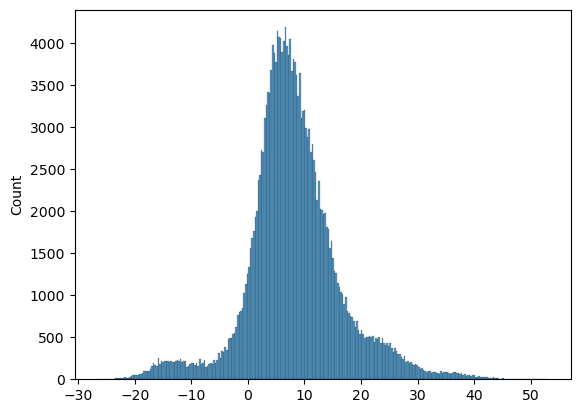

In [161]:
sns.histplot(mus.flatten())

<Axes: ylabel='Count'>

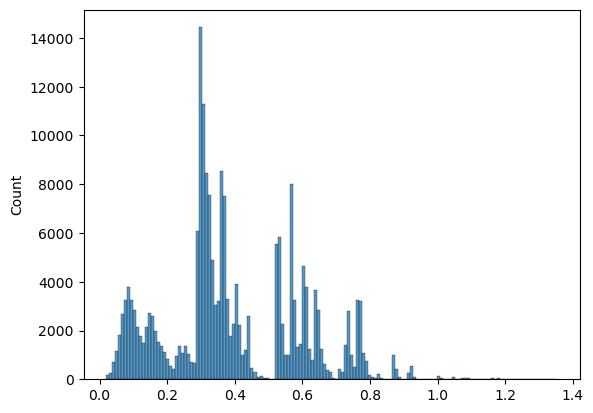

In [162]:
sns.histplot(sigs.flatten())

In [163]:
mus.shape

(2099, 100)

# Write out the group ids, which will be the advertiser ids

In [92]:
len(advertiser_ids)

59

In [93]:
groups = []
for cid in sorted(top_campaigns):
    group_id = advertiser_ids.index(campaign_to_advertiser[cid])
    print(cid, group_id)
    groups.append(group_id)

124391 25
184750 24
191254 24
197246 24
197257 24
197349 47
197912 28
198951 19
205843 24
208037 24
208435 29
208469 52
208878 11
209150 27
210361 46
210362 46
210633 44
210635 44
210685 7
210702 7
210802 7
211167 6
211305 21
211331 13
211332 13
211499 9
211516 9
211518 9
211520 9
211521 9
211522 0
211733 9
211831 39
211853 39
211950 12
211998 30
212176 3
212229 49
212246 8
212923 42
212971 23
213012 51
213131 53
213287 22
213314 4
213315 4
213336 55
213351 32
213370 54
213453 56
213454 56
213708 48
213745 33
213746 33
213783 45
213877 41
213879 41
213912 37
213956 2
214002 16
214003 16
214126 20
214175 5
214320 10
214323 10
214397 31
214483 1
214490 1
214515 36
214520 36
214593 38
214626 1
214627 1
214630 1
214631 1
214633 1
214647 0
214693 18
214698 18
214774 43
214871 50
214873 50
214875 50
214879 50
214881 50
214883 50
214937 38
215116 17
215197 26
215250 34
215393 44
215401 15
215407 42
215456 35
215471 40
215482 0
215529 57
215548 14
215592 58
215885 44


In [94]:
np.save(os.path.join(data_dir, "groups.npy"), groups)

In [95]:
len(groups)

100

In [96]:
mus.shape

(2099, 100)

In [97]:
sigs.shape

(2099, 100)

In [164]:
np.min(np.reshape(mus[:, 30], (-1, 1))-mus[:, 32:])

-3.52173275873065

In [117]:
sorted(top_campaigns)[31]

'211733'

In [116]:
mus[:, 31]

array([ 3.68520687,  8.7488882 , 10.76969314, ..., -0.91049485,
       -0.91049485, -0.91049485])

In [110]:
df['seconds_played'] = df['seconds_played'].astype(int)

In [114]:
means = df.groupby(['campaign_id'])['seconds_played'].mean()

In [121]:
means

campaign_id
124391     7.013158
184750     6.755102
191254     5.216667
197246    12.547170
197257     4.338028
            ...    
215482     5.762500
215529    11.820513
215548     6.260000
215592    10.187500
215885     5.031250
Name: seconds_played, Length: 100, dtype: float64

In [122]:
sorted(top_campaigns).index("197246")

3

In [127]:
means['197246']

12.547169811320755

In [126]:
np.mean(mus[:, 3])

7.113551024015932

In [130]:
np.mean(mus[:, 30])

11.75783249916437

In [129]:
means['211733']

1.6355140186915889

In [131]:
mus[:, 30]

array([13.52627851, 18.58995985, 20.61076478, ...,  8.93057679,
        8.93057679,  8.93057679])

In [132]:
sigs[:, 30]

array([0.4049287 , 0.59492445, 0.41787889, ..., 0.312141  , 0.312141  ,
       0.312141  ])

In [135]:
sigs[:, 3]

array([0.38223059, 0.58437797, 0.39284898, ..., 0.27519635, 0.27519635,
       0.27519635])

In [136]:
mus[:, 3]

array([ 8.88199703, 13.94567837, 15.9664833 , ...,  4.28629531,
        4.28629531,  4.28629531])